<a href="https://colab.research.google.com/github/nicholas99212/DS1002/blob/main/05_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from multiprocessing.pool import Pool
import seaborn as sns
import pickle

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."
...,...
18629,"[date, a, lonely, housewife, always, wanted, t..."
18630,"[request, submitted, :, access, request, for, ..."
18631,"[re, :, important, -, prc, mtg, hi, dorn, &, j..."
18632,"[press, clippings, -, letter, on, californian,..."


To clean the tokens, I would remove common words such as "and," "the," and "re;." I would then encode the remaining words as dummy variables and run an algorithm that predicts the correlation between phishing emails and these words.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

    token  count
0     new   1365
1    date   1202
2     get   1052
3  please   1022
4   enron    927


,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


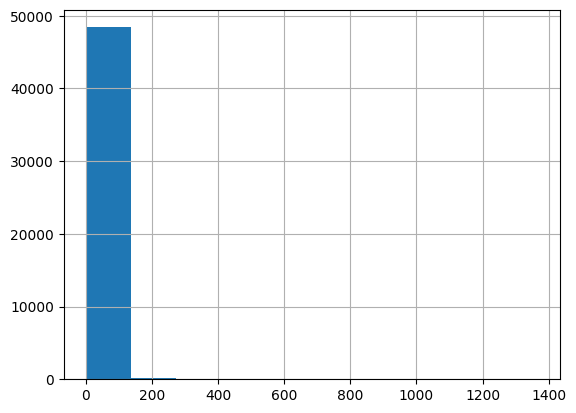

In [7]:
with open('/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

data = pd.DataFrame(token_freq, columns=['token', 'count'])
data['count'].hist()
print(data.head())
data.describe()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

Based on the histogram, there is a long tail where some words are extremely frequent while some words only show up once or twice. "new," "date," and "get" are the most common words and all show up over a 1000 times. In addition, over half of the tokens only show up once.

Q3.

Load Phishing_clean.parquet. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the Email Type takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

Perform an 80/20 train-test split of the data.
Run a regression of  on the one-hot-encoded emails. What is the  on the test set? On the training set?
What words have the largest coefficients in absolute value and most strongly influence predictions?

In [25]:
df = pd.read_parquet('/Phishing_clean.parquet')

X = df.drop(columns='Email Type')
y = df['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


model = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

train_r2 = r2_score(y_hat_train,y_train)
test_r2 = r2_score(y_hat_test,y_test)

print(train_r2)
print(test_r2)

0.6247069991348556
-4.7744715939268545e-05


The model has a strong R2 of .62 on the test set, but appears to struggle from overfitting and has a negative R2 for the training set.

In [11]:
table = pd.DataFrame({'variable': model.feature_names_in_ , 'value': model.coef_})
table['abs coeff'] = table['value'].abs()
table_sorted = table.sort_values('abs coeff', ascending=False)

print(table_sorted.head(10))

                                               variable         value  \
74                                                2002,  1.220497e+13   
1014                                               8859 -8.298006e+12   
340                                                2005 -5.779494e+12   
915                                                 300  5.171208e+12   
1133                                                19,  4.791183e+12   
1715                                            endlogo -4.556636e+12   
1539                                             visuai -3.869378e+12   
1570                                                400 -3.710622e+12   
72                                                 1998 -3.559339e+12   
1798  url(http://images.lockergnome.com/images/issue...  3.241139e+12   

         abs coeff  
74    1.220497e+13  
1014  8.298006e+12  
340   5.779494e+12  
915   5.171208e+12  
1133  4.791183e+12  
1715  4.556636e+12  
1539  3.869378e+12  
1570  3.710622e+12  
72    3

The words with the largest coefficients are all numbers. This doesn't make a ton of sense, or at least arent' the words I would expect to be correlated with scams. This could incicate that the model is having a hard time identifying what leads to scams.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

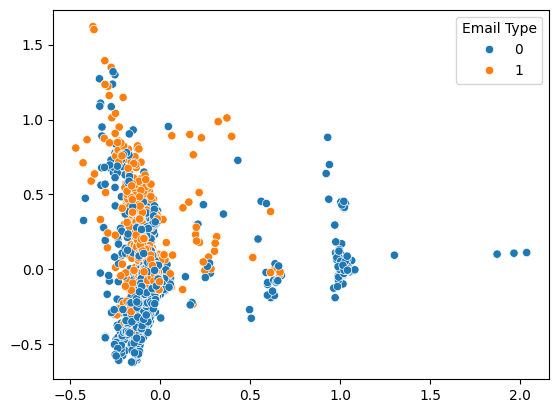

In [22]:
Modelpca = PCA(n_components=2).fit(X_train)
Z_train = Modelpca.transform(X_train)
Z_test = Modelpca.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The scam emails appear to have a greater 2nd component than 1st component

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [26]:
Modelpca = PCA(n_components=2610).fit(X_train)

Z_train = Modelpca.transform(X_train)
Z_test = Modelpca.transform(X_test)

model = LinearRegression().fit(Z_train,y_train)
y_hat_test = model.predict(Z_test)
y_hat_train = model.predict(Z_train)

print('Old Train R2:', train_r2)
print('New Test R2:', test_r2, '\n')

print('New Train R2: ', r2_score(y_hat_train,y_train) )
print('New Test R2: ', r2_score(y_hat_test,y_test) )

Old Train R2: 0.6247069991348556
New Test R2: -4.7744715939268545e-05 

New Train R2:  0.6967854877754098
New Test R2:  0.5761002613787811


While the Train R2 is similar to the original linear regression, the Test R2 has significantly improved and is similar to the Train 2. This means that PCA has helped with the overfitting that the original model suffered from.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

With the original data, our model suffered from overfitting and multi-collinearity in its predictions. By using PCA, the variables become independent of eachother and can be more effectively used in a regression. In terms of drawbacks, the results from the original regression are easier to interpret as the independent variables are words rather than components